In [33]:
%matplotlib inline

In [34]:
import pandas as pd
import numpy as np
import time
import datetime
import os
import matplotlib.pyplot as plt

In [35]:
from scipy.optimize import minimize

In [36]:
from sklearn.metrics import r2_score

In [37]:
import json

# import data 

In [38]:
daily_data_dir = './../data/daily_data/'

In [39]:
os.listdir(daily_data_dir)

['daily_data_ready.zip',
 'daily_data_clean_20171110.zip',
 'daily_before_adjust_data_funds.csv',
 'funds_daily.csv',
 'funds_daily.zip',
 'daily_after_adjust_data_funds.csv',
 '.ipynb_checkpoints',
 'daily_data_ready.csv',
 'daily_fund_style_index_data.csv',
 'daily_no_adjust_data_funds.csv']

In [41]:
daily_data = pd.read_csv(os.path.join(daily_data_dir, 'daily_data_clean_20171111.csv'), encoding='utf-8')

IOError: File ./../data/daily_data/daily_data_clean_20171111.csv does not exist

In [29]:
fund_code_list = daily_data['code'].unique().tolist()

NameError: name 'daily_data' is not defined

In [10]:
print 'There are {} funds in total.'.format(len(fund_code_list))

NameError: name 'fund_code_list' is not defined

In [11]:
fund_style_list = ['hs300g_daily_return', 'bond_long_daily_return', 'bond_medium_daily_return',
                  'bond_short_daily_return', 'hs300v_daily_return', 'zz1000_daily_return',
                  'zz500g_daily_return', 'zz500v_daily_return']

In [12]:
def fund_style_coef(fund_data, fund_style_list, target, interval, print_shape=False):
    """
        Given fund code and interval, return the coefficient
    """
    fund_coef_dict = {}
    for year in fund_data['year'].unique().tolist():
        tmp = fund_data[fund_data['year'] == year]
        for epoch in tmp[interval].unique().tolist():
            data = tmp[tmp[interval] == epoch]
            X = data.as_matrix(fund_style_list)
            X = X.T
            y = data.as_matrix([target])
            y = np.ravel(y)
            if print_shape:
                print 'code: {}, X:{}, y:{}'.format(data['code'], X.shape, y.shape)
            x0 = np.zeros(X.shape[0])
    
            def loss(x):
                return np.sum(np.square(np.dot(x,X) - y))
    
            cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1.0})
    
            x0 = np.zeros(X.shape[0])
            res = minimize(loss, x0, method='SLSQP', constraints=cons,
                  bounds=[(0, np.inf) for i in range(X.shape[0])], options={'disp':False})
            y_pred = np.dot(res.x, X)
            r_squared = r2_score(y, y_pred)
            # put ceof into a dict
            fund_coef_dict[str(year)+'-'+str(epoch)] = {'r_squared':r_squared}
            for i in xrange(len(fund_style_list)):
                fund_coef_dict[str(year)+'-'+str(epoch)][fund_style_list[i]+'_coef'] = res.x[i]
   
    fund_style_coef_list = []
    for i in fund_style_list:
        fund_style_coef_list += [i+'_coef']
    return pd.DataFrame(fund_coef_dict).T, fund_style_coef_list


In [13]:
# total_alpha, select_alpha, style_alpha = alpha_calculate(test_fund_data_month.copy(),
#                                         fund_style_list, 'net_restore_return', benchmark, 'month', df_month)

In [14]:
def alpha_calculate(fund_data, fund_style_list, target, benchmark_index, interval, coef):
    """
        Given benchmark, return the select alpha and style alpha
    """
    
    total_alpha = []
    select_alpha = []
    style_alpha = []
    
    #merge fund_data and coef
    coef['date'] = coef.index 
    coef['year'] = coef['date'].apply(lambda x: int(x[:4]))
    coef[interval] = coef['date'].apply(lambda x: int(x[5:]))
    del coef['date']
    fund_data = pd.merge(fund_data, coef, on=['year', interval])
#     print fund_data.columns
    fund_data.sort_values(['year', 'month', 'day'], ascending=[True, True, True], inplace=True)
    fund_style_coef_list = []
    for i in fund_style_list:
            fund_style_coef_list +=[i+'_coef']
    for year in fund_data['year'].unique().tolist():
        tmp = fund_data[fund_data['year'] == year]
        for epoch in tmp[interval].unique().tolist():
            data = tmp[tmp[interval] == epoch]
            coef_i = data.as_matrix(fund_style_coef_list)
            X_i = data.as_matrix(fund_style_list)
            fund_style_return_i = np.sum(np.multiply(X_i, coef_i),axis=1)

#             total_alpha_i = (data[target]) - (data[benchmark_index])
#             style_alpha_i = (fund_style_return_i) - (data[benchmark_index])
#             select_alpha_i = (data[target]) - (fund_style_return_i)
            target_return = 1.0
            benchmark_return = 1.0
            fund_style_return = 1.0
            for t, b, f in zip(data[target], data[benchmark_index], fund_style_return_i):
                target_return *= (1 + t)
                benchmark_return *=(1 + b)
                fund_style_return *=(1 + f)
            total_alpha_i = (target_return - 1) - (benchmark_return - 1)
            style_alpha_i = (fund_style_return - 1) - (benchmark_return - 1)
            select_alpha_i = (target_return - 1) - (fund_style_return - 1)
            total_alpha += [total_alpha_i]
            style_alpha += [style_alpha_i]
            select_alpha += [select_alpha_i]
    return total_alpha, select_alpha, style_alpha
#             print np.sum(np.multiply(X_i, coef_i), axis=1).shape, data[target].shape
#             print X_i
#             fund_style_return = np.dot(X_i, coef_i.T)

In [15]:
def fund_nv(fund_data, target, interval, benchmark_index):
    """
        Given benchmark and interval, return nv values
    """
    target_values = []
    benchmark_values = []
    
    nv_tar = 1.0
    nv_bench = 1.0
    for year in fund_data['year'].unique().tolist():
        tmp = fund_data[fund_data['year'] == year]
        for epoch in tmp[interval].unique().tolist():
            data = tmp[tmp[interval] == epoch]
            for tar, bench in data[[target, benchmark_index]].values:
                nv_tar *= (1 + tar)
                nv_bench *= (1 + bench)
            target_values.append(nv_tar)
            benchmark_values.append(nv_bench)
    return target_values, benchmark_values

In [16]:
def plot_result(data, fund_style_coef_list, fund_style_index_list, select_alpha, style_alpha, benchmark, target):
    """
        Given data, return all the required plot
    """

    plt.figure(figsize=(10,10))
    plt.subplot(322)
    tmp = data[fund_style_coef_list].values
    plt.stackplot(range(len(tmp)), tmp.T, labels=fund_style_index_list)
    plt.legend(bbox_to_anchor=(0.0,1.0))
    plt.subplot(323)
    plt.bar(range(len(data['r_squared'])), data['r_squared'])
    plt.title('R^2')
    plt.subplot(324)
    plt.bar(range(len(select_alpha)), select_alpha)
    plt.title('Select alpha')
    plt.subplot(325)
    plt.bar(range(len(style_alpha)), style_alpha)
    plt.title('Style alpha')
    plt.subplot(326)
    plt.plot(target)
    plt.plot(benchmark)
    plt.title("fund nv")

In [17]:
tmp = pd.to_datetime(daily_data['date'])
daily_data.loc[:,'year'] = tmp.dt.year
daily_data.loc[:,'month'] = tmp.dt.month
daily_data.loc[:,'date'] = tmp.dt.date
daily_data.loc[:, 'day'] = tmp.dt.day

NameError: name 'daily_data' is not defined

# select one ideal fund

In [18]:
# fund_style_index_list = daily_data.columns[6:]
#select one fund
# for i in range(len(fund_code_list)):
test_fund_data = daily_data[daily_data['code'] == '000011.OF']
test_fund_data = test_fund_data.dropna(how='any')
benchmark = 'hs300_daily_return'
test_fund_data.head()
# 000001.OF', u'000011.OF', u'002031.OF
#     test_fund_data_month = test_fund_data
#     df_month, fund_style_coef_list = fund_style_coef(test_fund_data_month, fund_style_list, 'net_unit_return', 'month')
#     if np.mean(df_month['r_squared']) > 0.9:
#         print i,

NameError: name 'daily_data' is not defined

# monthly regression

In [50]:
test_fund_data_month = test_fund_data.copy()
df_month, fund_style_coef_list = fund_style_coef(test_fund_data_month.copy(), fund_style_list, 'net_restore_return', 'month')
# np.sum(df_month[fund_style_coef_list].values, axis=1)
np.mean(df_month['r_squared'])

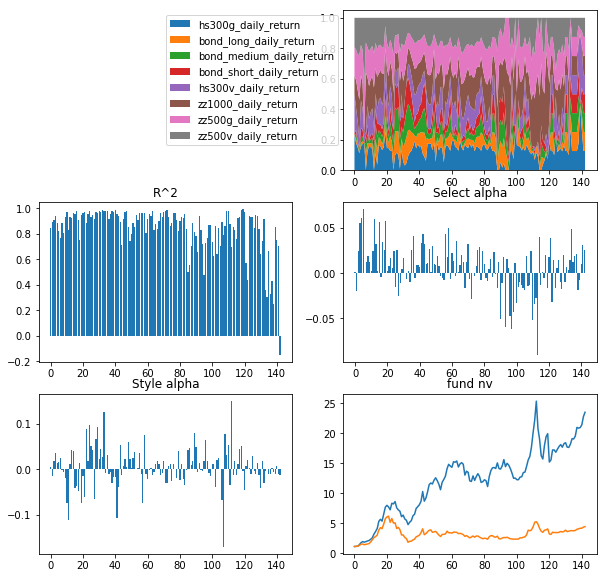

In [51]:
# df_month[fund_style_index_list].plot(kind='area')
# df_month[fund_style_coef_list].plot(kind='area')

# df['r_squared'].plot()
# df_month['r_squared'].plot(kind='bar')

total_alpha, select_alpha, style_alpha = alpha_calculate(test_fund_data_month.copy(),
                                        fund_style_list, 'net_restore_return', benchmark, 'month', df_month)

# test_fund_data.head()

# plt.bar(range(len(select_alpha)), select_alpha)

# plt.bar(range(len(select_alpha)), select_alpha)

# plt.bar(range(len(style_alpha)), style_alpha)

target_values, benchmark_values = fund_nv(test_fund_data_month.copy(), 'net_restore_return', 'month', benchmark)


# plt.plot(target_values)
# plt.plot(benchmark_values)

plot_result(df_month, fund_style_coef_list, fund_style_list, 
            select_alpha, style_alpha, benchmark_values, target_values)

# season regression

In [52]:
def get_season(data):
    if data in range(1, 4):
        return 1
    elif data in range(4, 7):
        return 2
    elif data in range(7,10):
        return 3
    else:
        return 4

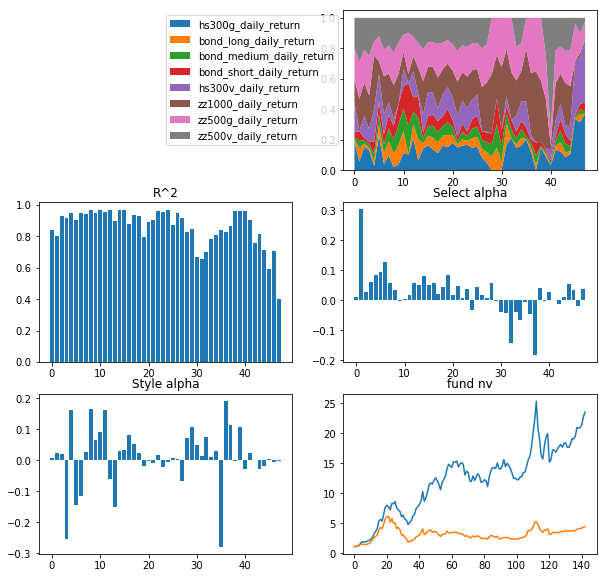

In [53]:
test_fund_data_season = test_fund_data
test_fund_data_season['season'] = test_fund_data['month'].apply(get_season)
df_season, fund_style_coef_list = fund_style_coef(test_fund_data_season, fund_style_list, 'net_restore_return', 'season')
total_alpha, select_alpha, style_alpha = alpha_calculate(test_fund_data_season, 
                                    fund_style_list, 'net_restore_return', benchmark, 'season', df_season)
# test_fund_data.head()
plot_result(df_season, fund_style_coef_list, fund_style_list, 
            select_alpha, style_alpha, benchmark_values, target_values)

# half-year regression

In [54]:
def get_half_year(data):
    if data in range(1, 7):
        return 1
    else:
        return 2

In [55]:
test_fund_data_half_year = test_fund_data
test_fund_data_half_year['half_year'] = test_fund_data['month'].apply(get_half_year)

In [56]:
df_half_year, fund_style_coef_list= fund_style_coef(test_fund_data_half_year, fund_style_list, 'net_restore_return', 'half_year')

# df_half_year[fund_style_coef_list].plot(kind='area')

# df_half_year['r_squared'].plot(kind='bar')

total_alpha, select_alpha, style_alpha = alpha_calculate(test_fund_data_half_year, 
                                    fund_style_list, 'net_restore_return', benchmark, 'half_year', df_half_year)
# test_fund_data.head()

# plt.bar(range(len(select_alpha)), select_alpha)

# plt.bar(range(len(style_alpha)), style_alpha)

target_values, benchmark_values = fund_nv(test_fund_data_half_year, 'net_restore_return', 'half_year', benchmark)
# plt.plot(target_values)
# plt.plot(benchmark_values)
np.mean(df_half_year['r_squared'])

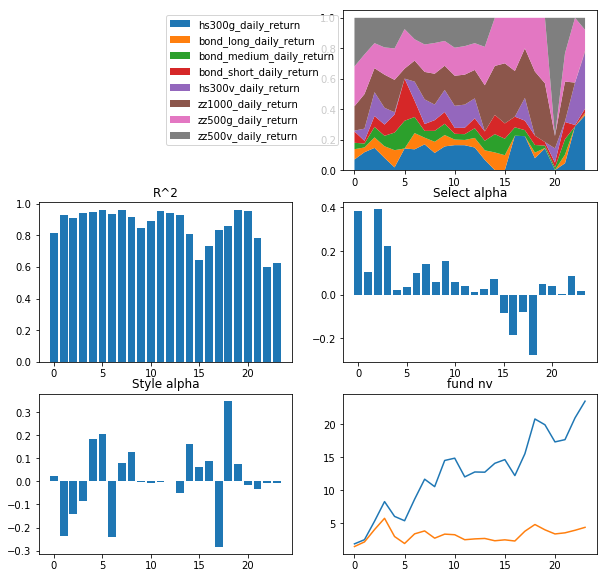

In [57]:
plot_result(df_half_year, fund_style_coef_list, fund_style_list, 
            select_alpha, style_alpha, benchmark_values, target_values)

# First figure in the report

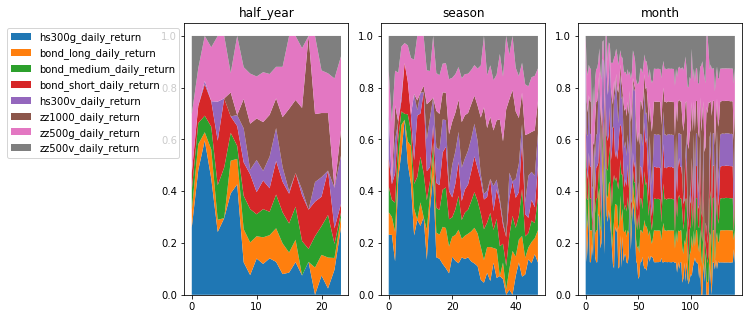

In [48]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.stackplot(range(len(df_half_year[fund_style_coef_list].values)), df_half_year[fund_style_coef_list].values.T,
             labels=fund_style_list)
plt.legend(bbox_to_anchor=(0.0,1.0))
plt.title("half_year")

plt.subplot(132)
plt.stackplot(range(len(df_season[fund_style_coef_list].values)), df_season[fund_style_coef_list].values.T,
             labels=fund_style_list)
# plt.legend(bbox_to_anchor=(0.0,1.0))
plt.title("season")


plt.subplot(133)
plt.stackplot(range(len(df_month[fund_style_coef_list].values)), df_month[fund_style_coef_list].values.T,
             labels=fund_style_list)
# plt.legend(bbox_to_anchor=(0.0,1.0))
plt.title("month")

In [ ]:
# bonds_list = ['bond_long_daily_close', 'bond_medium_daily_close', 'bond_short_daily_close']
# daily_data[bonds_list].plot()

# save monthly file

In [ ]:
# today = datetime.date.today().strfttime('%Y%m%d')

In [ ]:
# daily_result_dir = './../results/daily_data/'

In [ ]:
# if not os.path.exists(os.path.join(daily_results_dir, today))
#     os.mkdir(os.path.join(daily_results_dir, today))

In [ ]:
# results_save_dir = os.path.join(daily_results_dir, today)